<a href="https://colab.research.google.com/github/luke-scot/emissions-tracking/blob/main/notebooks/LCA_data_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install floweaver ipysankeywidget

# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm
import seaborn as sns
import itertools
import ipywidgets as ipw
import scipy.stats as stats
from floweaver import *
from ipysankeywidget import SankeyWidget
import gdown, os
from google.colab import files

"""Import example data"""
# Import and unzip files -> You can then view them in the left files panel
folder, zip_path = 'data', 'data.zip'
if not os.path.exists(folder): 
  gdown.download('https://drive.google.com/uc?id=1Mfsng1fdod8Ng_dBMyZ8SwG4oKo-0ZFm', zip_path ,quiet=True)
  ! unzip $zip_path -d 'data'
  ! rm $zip_path

import data.utilities as utl

# Variable definition
# lcaDataPath = "C:/Users\lukec\OneDrive - University of Cambridge\Projects\PhD\Data\EcoInvent\EcoInvent_B0729/xml_openLCA"
# inOutPath = "C:/Users\lukec\OneDrive - University of Cambridge\Projects\PhD\Data\EcoInvent\EcoInvent_B0729/xml_EI/"
impactMethods = "data/IPCC2013.xml"
processes_file = "data/GWP100a_IPCC2013.csv"

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
# Read in impact factors
def read_xml_attributes(filepath:str,branches:list,attributes:list,df=False):
    """This function creates a dataframe of attributes within an xml file.\n
    Inputs:\n
    filepath - path to xml file\n
    branches - list of successive branch choices\n
    attributes - attributes to be read from chosen branch\n
    Outputs:\n
    df - pandas dataframe of attributes for each end branch\n
    Requirements: pandas as pd, xml.etree.ElementTree as ET"""
    if df is False: df = pd.DataFrame([],columns=[i for sublist in utl.to_listlist(attributes) for i in sublist])
    tree_loc = ET.parse(filepath).getroot()
    branches, attributes = utl.to_listlist(branches), utl.to_listlist(attributes)
    attr_values = dict()
    for pathnum, path in enumerate(branches):
        for branch in path:
            for num,val in enumerate([branch in i.tag for i in tree_loc]):
                if val:
                    if branch is path[-1]:
                        attr_values.update(dict(zip(attributes[pathnum],[tree_loc[num].attrib[i] if i else tree_loc[num].text for i in attributes[pathnum]])))
                        if path is branches[-1]: df = df.append(attr_values,ignore_index=True)
                    else:
                        tree_loc=tree_loc[num]
                        break
    return df

In [4]:
# Fetch and display impact factors
impacts = read_xml_attributes(impactMethods,['dataset','flowData','exchange'],['name','category','subCategory','meanValue'])
impacts.sort_values('name')

,name,category,subCategory,meanValue
56,"Carbon dioxide, fossil",Emission to air,unspecified,1.0
45,"Carbon dioxide, fossil",Emission to air,low population density,1.0
164,"Carbon dioxide, fossil",Emission to air,"low population density, long-term",1.0
69,"Carbon dioxide, fossil",Emission to air,lower stratosphere + upper troposphere,1.0
19,"Carbon dioxide, fossil",Emission to air,high population density,1.0
...,...,...,...,...
189,Sulfur hexafluoride,Emission to air,lower stratosphere + upper troposphere,23506.81999316
79,Sulfur hexafluoride,Emission to air,"low population density, long-term",23506.81999316
44,Sulfur hexafluoride,Emission to air,low population density,23506.81999316
3,Sulfur hexafluoride,Emission to air,unspecified,23506.81999316


In [5]:
# Load in xml data to dataframe
def calculate_co2e(filepath:str, lookup:pd.DataFrame, branches:list=None, attributes:list=None):
    """This function calculates total CO2e impacts for processes given the outputs and impact factors\n
    Inputs:\n
    filepath - path to process xml file\n
    lookup - dataframe with CO2e values for a unit of output materials\n
    branches - branches for outputs in xml file\n
    attributes - attributes at destination branch in xml file\n
    Output: Float of total CO2e due to process.\n
    Requirements: pandas as pd, read_xml_attributes function"""
    # Defaults
    if attributes is None: attributes = ['name', 'category', 'subCategory', 'meanValue']
    if branches is None: branches = ['dataset', 'flowData', 'exchange']
    # Calculation
    product = read_xml_attributes(filepath,branches,attributes)
    product = product.rename(columns={attributes[-1]: "kg"})
    emissions = product.merge(lookup)
    return sum(pd.to_numeric(emissions['kg'])*pd.to_numeric(emissions[attributes[-1]]))

def import_xml_batch(directory:str,path:list,attributes:list,co2e=False,impacts=False):
    """This function imports xml data into a pandas dataframe inputs:\n
    directory - directory of xml files\n
    path - location of attributes within xml\n
    attributes - names of attributes/column names\n
    outputs:\n
    df - dataframe of requested attributes\n
    Requirements: os, pandas as pd, xml.etree.ElementTree as ET"""
    file_list = os.listdir(directory)
    attributes = utl.to_listlist(attributes)
    df = pd.DataFrame([],columns=[j for i in attributes for j in i])
    if co2e is not False: df[co2e] = None
    for file in tqdm(file_list):
        df = read_xml_attributes(os.path.join(directory, file),path,attributes,df)
        if co2e is not False: df[co2e].iloc[-1] = calculate_co2e(os.path.join(directory, file), impacts)
    return df, file_list

#processes, _ = import_xml_batch(lcaDataPath,[['dataset','meta','process','reference'],['dataset','meta','process','geo']],[['name','generalComment'],['location']],'CO2e',impacts)

In [6]:
# Save or load processes file
if 'processes' in locals(): processes.sort_values('name').to_csv(processes_file)
else: processes = pd.read_csv(processes_file,index_col=0)

In [7]:
# Filter dataframe for non market activities
production = processes[~ processes['generalComment'].str.contains('market')].sort_values('name')
production

,name,generalComment,location,CO2e
249,barite,This dataset refers to the production of 1 kg ...,BR,0.020889
241,barite,This dataset has been copied from an original ...,RoW,0.031836
142,bauxite,Average moisture content of bauxite is approxi...,GLO,0.012219
114,bulk lead-zinc concentrate,"The multi-output ""zinc mine operation"" process...",GLO,0.418987
224,"calcium carbonate, precipitated",For the separation and refining of rare earth ...,CN-SC,3.496398
...,...,...,...,...
51,zinc concentrate,From metal containing ore extraction from the ...,CA-QC,0.463061
126,zinc concentrate,"The multi-output ""zinc mine operation"" process...",GLO,0.438609
192,"zircon, 50% zirconium",This dataset refers to the production of 1 kg ...,AU,0.410540
226,"zircon, 50% zirconium",Heavy mineral sands are a class of ore deposit...,ZA,1.319584


In [8]:
# Default product components
product_name="Luke's machine"
components = ['gold','barite','copper concentrate, sulfide ore','iron ore concentrate']
quantity = [0.01,100,100,90]
plot_props = {'style':'white','font_scale':1.5,'cmap':plt.cm.get_cmap('tab10').colors}

In [9]:
# Define function to plot footprint distribution according to components
sns.set_theme(style=plot_props['style'], font_scale=plot_props['font_scale'])

def get_footprint_dist(components:list,quantity:list,data:pd.DataFrame,provenance:list=False,name_col:str='name',plot:bool=True,
                       plot_props:dict=None,product_name:str='Product',sea=False,sankey=True):
    """This function outputs the distribution of possible emissions due to a product according to its composition\n
    Inputs:\n
    components - list of product components\n
    quantity - quantity in kg of eah product\n
    data - dataframe containing emissions due to components\n
    name_col - column name for components in dataframe\n
    plot - True outputs distribution plot\n
    Outputs:\n
    emission_dist - dataframe of rows with emissions for each possible pathway\n
    plot - distribution plot with emissions according to each component"""
    # Get database of process emissions according to components
    proc_emissions = data.copy()[[i in components for i in data[name_col]]]
    if provenance:
        proc_emissions = proc_emissions.iloc[np.where(sum([np.logical_and(proc_emissions[name_col]==components[i], [k in prov for k in proc_emissions.location]) if 'Unknown' not in prov else proc_emissions[name_col]==components[i] for i, prov in enumerate(provenance)]))[0]]
    proc_emissions.CO2e = proc_emissions.CO2e*[quantity[i] for i in [components.index(i) for i in proc_emissions[name_col]]]

    # Find all possible supply chains
    num_comps = len(components)
    combinations = [proc_emissions[name_col][i] for i in [list(i) for i in list(itertools.combinations(proc_emissions.index, num_comps))]]
    chains = [combinations[i] for i in np.where([len(set(i)) == num_comps for i in combinations])[0]]

    # Get emissions for all possible supply chains
    emission_dist = pd.DataFrame(np.asarray([proc_emissions.loc[i.index].CO2e for i in chains]),columns=np.sort(components))
    emission_dist['Total']=emission_dist.sum(axis=1)
    if sea:
        # Default + update variables
        rcps = {'cmap': plt.cm.get_cmap('tab10').colors, 'kind':'kde', 'fill':True, 'cut':0, 'log_scale':[False,True], 'height':7, 'aspect':1.5, 'alpha':0.65, 'title':product_name+' CO2e footprint\n'+'Mean: '+str(round(emission_dist['Total'].mean(),2))+'t Stdev: '+str(round(emission_dist['Total'].std(),2))+'t','xlabel':'Emissions (t CO2e)', 'ylabel':'Probability'}
        if plot_props: rcps.update(plot_props)
        # Plot distributions
        sns.displot(emission_dist, kind=rcps['kind'], fill=rcps['fill'], hue_order=np.flip(emission_dist.columns), cut=rcps['cut'], log_scale=rcps['log_scale'], height=rcps['height'], aspect=rcps['aspect'], alpha=rcps['alpha'], warn_singular=False).set(title=rcps['title'],xlabel=rcps['xlabel'], ylabel=rcps['ylabel'])
        # Plot single lines for collapsed distributions
        lines = np.flip([emission_dist[i].unique()[0] if len(emission_dist[i].unique())==1 else 0 for i in emission_dist.columns])
        plt.vlines(lines,color=rcps['cmap'][:len(emission_dist.columns)], ymin=0, ymax=1, alpha=[i>0 for i in lines])
        plt.show()
    elif plot:
        fig, ax = plt.subplots(1,1,figsize=[12,8])
        for name, mu, sigma in zip(np.flip(emission_dist.columns), np.flip(np.mean(emission_dist)), np.flip(np.std(emission_dist))):
            if sigma<0.1: sigma+=0.05*mu
            x = np.linspace(mu-sigma, mu+3*sigma, 100)
            ax.set_yscale('log'), ax.set_xlabel('Emissions (t CO2e)'), ax.set_ylabel('Probability')
            ax.set_title(product_name+' CO2e footprint\n'+'Mean: '+str(round(emission_dist['Total'].mean(),2))+'t Stdev: '+str(round(emission_dist['Total'].std(),2))+'t')
            ax.set_ylim([5E-4,1])
            ax.fill_between(x, stats.norm.pdf(x, mu, sigma),alpha=0.5,label=name)
            ax.text(mu,max(stats.norm.pdf(x, mu, sigma)),round(mu))

        ax.legend()
        plt.show()
    if sankey:
        sankey_df = pd.DataFrame([],columns=['source', 'target','value','type'])
        sankey_df['source'] = emission_dist.columns[:-1].values
        sankey_df['target'] =[product_name]*len(emission_dist.columns[:-1])
        sankey_df['value'] = list(np.mean(emission_dist)[:-1])
        sankey_df['type'] = np.arange(0,len(emission_dist.columns[:-1]),1)
        display(SankeyWidget(links=sankey_df.to_dict('records')))
    return emission_dist

In [10]:
# Define components
components_wg = ipw.SelectMultiple(options=production.name.unique(),value=components,rows=10,description='Components', disabled=False)
display(components_wg)

SelectMultiple(description='Components', index=(13, 0, 7, 19), options=('barite', 'bauxite', 'bulk lead-zinc c…

In [11]:
# Set quantities and provenance of components
quantity_wg = ipw.HBox([ipw.FloatLogSlider(value=quantity[num], description=i, base=10, min=-3, max=4, step=0.01, disabled=False) for num,i in enumerate(list(components_wg.value))])
provenance_wg = ipw.HBox([ipw.SelectMultiple(options=['Unknown']+list(production[production.name==j].location.values), description=j, value=['Unknown']) for j in list(components_wg.value)])
display(ipw.VBox([quantity_wg,provenance_wg]))

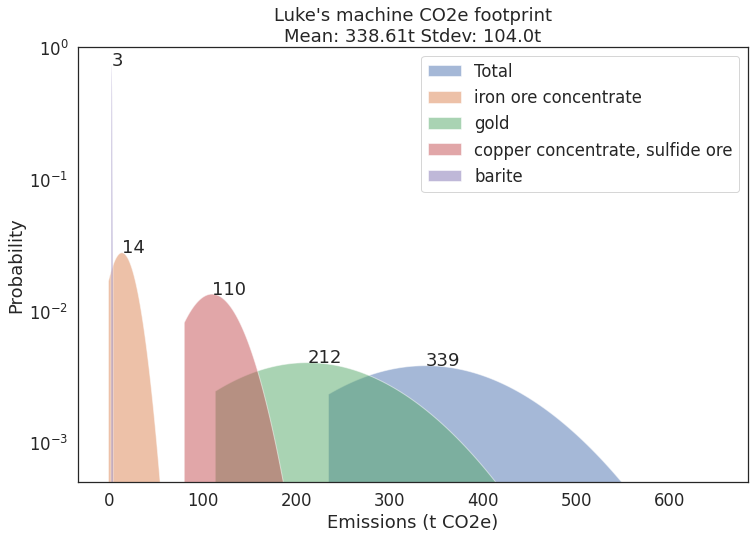

SankeyWidget(links=[{'source': 'barite', 'target': "Luke's machine", 'value': 2.636251228117877, 'type': 0}, {…

In [12]:
# Output footprint distributions for chosen product composition
emission_dist = get_footprint_dist(list(components_wg.value),list(map(lambda i: i.value, quantity_wg.children)),production,
                       provenance=list(map(lambda i: list(i.value), provenance_wg.children)), product_name=product_name)

# Importing from EcoSpold xml with pedigree matrices

In [ ]:
# Get data from all files into database
#for file in files
file = files[0]
read_xml_attributes(spold_path+file,[['activityDataset','flowData','intermediateExchange','name'],['activityDataset','flowData','intermediateExchange','uncertainty','lognormal']],[[False],['meanValue','mu','variance','varianceWithPedigreeUncertainty']])

,False,meanValue,mu,variance,varianceWithPedigreeUncertainty
0,blasting,7.73E-05,-9.47,0.02,0.0367


In [ ]:
spoldOrigin = '{http://www.EcoInvent.org/EcoSpold02}'
path = ['activityDataset','flowData','intermediateExchange']
assets = [['name'],['uncertainty','lognormal']]
attributes = [False,['meanValue','mu','variance','varianceWithPedigreeUncertainty']]
colNames = ['Process',False]

In [ ]:
files = os.listdir(inOutPath)
defaultVariance = 0.3
variance = np.ones([1,len(production)])*defaultVariance

for file in files:
    if 'inner' in globals(): del(inner, outer)
    root = ET.parse(inOutPath+file)
    df = pd.DataFrame([],columns=list(itertools.chain.from_iterable([[name] if name else attributes[colNum] for colNum, name in enumerate(colNames)])))
    elements = root.findall("//".join(list(map(lambda x: spoldOrigin+x,path))))
    for assetNum, asset in enumerate(assets[:-1]):
        for element in elements:
            current = element.find("//".join(list(map(lambda x: spoldOrigin+x,asset))))
            next = element.find("//".join(list(map(lambda x: spoldOrigin+x,assets[assetNum+1]))))
            current_att = current.attrib[attributes[assetNum]] if attributes[assetNum] else current.text
            if next is not None:
                next_att = [next.attrib[i] for i in attributes[assetNum+1]] if attributes[assetNum+1] else next.text
            else: next_att=None
            outer = outer+[current_att] if 'outer' in globals() else [current_att]
            inner = inner+[next_att] if 'inner' in globals() else [next_att]

    properties = [read_xml_attributes(inOutPath+file,path,[False]) for path in [['activityDataset','activityDescription','activity','activityName'],['activityDataset','activityDescription','geography','shortname']]]
    print(properties)
    sgl_process = dict(zip(['Process','Location'], list(map(lambda x: x.values[0][0], properties))))
    sgl_process.update({'Elements':outer,'Uncertainties':inner})

    prod_match = list(map(lambda x: list(map(lambda y: y in x, production['name'])), [sgl_process['Process']]))
    loc_match = list(map(lambda x: list(map(lambda y: y in x, production['location'])), [sgl_process['Location']]))
    correspondence = list(np.where(np.array(prod_match)+np.array(loc_match)==2))[1]
    if correspondence.size > 0:
        totals = [sum(list(map(float,[i[elem] if i else 0 for i in sgl_process['Uncertainties']]))) for elem in [1,3]]
        variance[correspondence] = abs(totals[1]/totals[0])


    # columns = colNames[pathNum] if colNames[pathNum] else str(attributes[pathNum])[1:-1]
    # print(columns)
    #  = np.array(list(map(lambda x: x.text if attributes[pathNum] is False else x.attrib, all_vals)))

[                                 False
0  asbestos production, crysotile type,   False
0   GLO]
[               False
0  barite production,    False
0  CA-QC]
[                                      False
0  boric acid production, anhydrous, powder,   False
0   RER]
[                                           False
0  hard coal mine operation, open cast, dragline,   False
0   GLO]
[                                           False
0  hard coal mine operation, open cast, dragline,   False
0    ZA]
[                                               False
0  hard coal mine operation, open cast, truck and...,   False
0   GLO]
[                                               False
0  hard coal mine operation, open cast, truck and...,   False
0    ZA]
[                                   False
0  hard coal mine operation, underground,   False
0   GLO]
[                                   False
0  hard coal mine operation, underground,   False
0    ZA]
[                   False
0  hard coal preparat

In [ ]:
production

,name,generalComment,location,CO2e
249,barite,This dataset refers to the production of 1 kg ...,BR,0.020889
241,barite,This dataset has been copied from an original ...,RoW,0.031836
142,bauxite,Average moisture content of bauxite is approxi...,GLO,0.012219
114,bulk lead-zinc concentrate,"The multi-output ""zinc mine operation"" process...",GLO,0.418987
224,"calcium carbonate, precipitated",For the separation and refining of rare earth ...,CN-SC,3.496398
...,...,...,...,...
51,zinc concentrate,From metal containing ore extraction from the ...,CA-QC,0.463061
126,zinc concentrate,"The multi-output ""zinc mine operation"" process...",GLO,0.438609
226,"zircon, 50% zirconium",Heavy mineral sands are a class of ore deposit...,ZA,1.319584
192,"zircon, 50% zirconium",This dataset refers to the production of 1 kg ...,AU,0.410540


In [ ]:
sgl_process['Uncertainties'][0][-1]

'0.0052'

In [ ]:
len(production)

166

C:\Users\lukec\AppData\Local\Temp/ipykernel_3492/3564030673.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if correspondance: production['variance'].iloc[correspondance] = sgl_process


In [ ]:
np.any(np.array(prod_match),np.array(loc_match))

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
read_xml_attributes(inOutPath+files[1],[['activityDataset','activityDescription','activity','activityName'],['activityDataset','activityDescription','geography','shortname']])

TypeError: read_xml_attributes() missing 1 required positional argument: 'attributes'

In [ ]:
sgl_process['Un']


{'Process': 'hard coal mine operation, underground',
 'Location': 'ZA',
 'Elements': ['limestone, crushed, washed',
  'mine infrastructure, underground, hard coal',
  'electricity, high voltage',
  'spoil from hard coal mining',
  'tap water',
  'diesel, burned in building machine',
  'blasting',
  'conveyor belt',
  'hard coal, run-of-mine'],
 'Uncertainties': [['0.00103', '-6.878', '0.0006', '0.0052'],
  ['1.67E-11', '-24.82', '0.3', '0.478'],
  ['0.0147', '-4.22', '0.02', '0.0232'],
  ['0.11', '-2.207', '5.5', '5.503'],
  ['0.02', '-3.912', '0.3', '0.3106'],
  ['0.013', '-4.343', '0.24', '0.2432'],
  ['1.71E-05', '-10.98', '0.9', '0.9032'],
  ['2.49E-06', '-12.9', '0.3', '0.3038'],
  None]}

In [ ]:
read_xml_attributes(inOutPath+files[0],['activityDataset','activityDescription','geography','shortname'],[False])

,False
0,GLO


In [ ]:
vals = [[False],[False]]

In [ ]:
properties = [read_xml_attributes(inOutPath+files[1],path,[False]) for path in [['activityDataset','activityDescription','activity','activityName'],['activityDataset','activityDescription','geography','shortname']]]

['barite production', 'CA-QC']